## Create image captioning dataset (Dataset Preparation)


In [ ]:
from datasets import load_dataset
from datasets import Image
from sklearn.model_selection import train_test_split
import os

jsonl_file = "/caption/FashionGen/caption.jsonl"
root = "/caption/FashionGen/image"

dataset = load_dataset("json", data_files=jsonl_file)
dataset = dataset["train"]

def add_root_to_image_path(example):
    example["image"] = os.path.join(root, example["image"])
    return example

dataset = dataset.map(add_root_to_image_path)

dataset = dataset.cast_column("image", Image(decode=True))


train_val_test = dataset.train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_test["test"].train_test_split(test_size=0.5, seed=42) 

train_dataset = train_val_test["train"]
val_dataset = val_test_split["train"]
test_dataset = val_test_split["test"]

In [10]:
from torch.utils.data import Dataset

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")

        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        encoding["attention_mask"] = encoding["input_ids"].ne(0).long()

        return encoding

In [ ]:
# from transformers import AutoProcessor
from transformers import AutoProcessor, AutoModelForCausalLM, CLIPImageProcessor, BertTokenizer

# processor = AutoProcessor.from_pretrained("microsoft/git-base")
class GitProcessor:
    '''
        Processor with BERT-Tokenizer
    '''
    def __init__(self, image_processor, tokenizer):
        self.image_processor = image_processor
        self.tokenizer = tokenizer

    def __call__(self, images=None, text=None, padding="max_length", return_tensors="pt"):
        
        inputs = {}
        if images is not None:
            inputs["pixel_values"] = self.image_processor(images=images, return_tensors=return_tensors)["pixel_values"]

        if text is not None:
            text_inputs = self.tokenizer(text, padding=padding, return_tensors=return_tensors, truncation=True)
            inputs.update(text_inputs)

        return inputs
image_processor = CLIPImageProcessor.from_pretrained('microsoft/git-base')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
processor = GitProcessor(image_processor, tokenizer)

In [12]:
train_data = ImageCaptioningDataset(train_dataset, processor)
test_data = ImageCaptioningDataset(test_dataset, processor)
val_data = ImageCaptioningDataset(val_dataset, processor)

In [13]:
item = train_data[0]
for k,v in item.items():
  print(k,v.shape)

Legacy behavior is being used. The current behavior will be deprecated in version 5.0.0. In the new behavior, if both images and text are provided, the last token (EOS token) of the input_ids and attention_mask tensors will be removed. To test the new behavior, set `legacy=False`as a processor call argument.


input_ids torch.Size([512])
attention_mask torch.Size([512])
pixel_values torch.Size([3, 224, 224])


In [14]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, shuffle=True, batch_size=16)
val_dataloader = DataLoader(val_data, shuffle=True, batch_size=16)
test_dataloader = DataLoader(test_data, shuffle=True, batch_size=16)

In [15]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

input_ids torch.Size([16, 512])
attention_mask torch.Size([16, 512])
pixel_values torch.Size([16, 3, 224, 224])


In [16]:
processor.decode(batch["input_ids"][0])

'[CLS] long sleeve neoprene mesh blazer in oxblood red. notched lapel. polished wood four - button closure at front. patch pockets. vented at back center seam. partially lined. tonal stitching. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

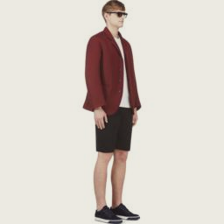

In [17]:
from PIL import Image
import numpy as np

MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255

unnormalized_image = (batch["pixel_values"][0].numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

## Model


In [18]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")

## Dummy forward pass


In [19]:
outputs = model(input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                pixel_values=batch["pixel_values"],
                labels=batch["input_ids"])
outputs.loss

tensor(11.7711, grad_fn=<NllLossBackward0>)

## Training the model

In [20]:
import torch

save_path = '/caption/model_path'
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
best_loss = float("inf")

for epoch in range(30):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    attention_mask = batch["attention_mask"].to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    attention_mask=attention_mask,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    # if loss.item() < best_loss:
    #     best_loss = loss.item()
    #     torch.save(model.state_dict(), f"{os.path.join(save_path, 'best_model_caption.pth')}")
        
torch.save(model.state_dict(), f"{os.path.join(save_path, 'last_model_caption_FG.pth')}")

Epoch: 0
Loss: 11.625798225402832
Loss: 10.316324234008789
Loss: 9.837018966674805
Loss: 9.57638168334961
Loss: 9.306083679199219
Loss: 9.086383819580078
Loss: 8.896530151367188
Loss: 8.679119110107422
Loss: 8.54133129119873
Loss: 8.354259490966797
Loss: 8.243918418884277
Loss: 8.085175514221191
Loss: 7.986233711242676
Loss: 7.881468296051025
Loss: 7.793471336364746
Loss: 7.653266429901123
Loss: 7.576372146606445
Loss: 7.464684009552002
Loss: 7.391977310180664
Loss: 7.263718128204346
Loss: 7.16414737701416
Loss: 7.067034721374512
Loss: 6.9790778160095215
Loss: 6.8894805908203125
Loss: 6.767463684082031
Loss: 6.676092147827148
Loss: 6.569174766540527
Loss: 6.441991329193115
Loss: 6.375301361083984
Loss: 6.262520790100098
Loss: 6.144564151763916
Loss: 6.0426812171936035
Loss: 5.939458847045898
Loss: 5.803089618682861
Loss: 5.735119819641113
Loss: 5.645129203796387
Loss: 5.535062789916992
Loss: 5.428623676300049
Loss: 5.323171615600586
Loss: 5.213935852050781
Loss: 5.083268642425537
Loss:

## Validation

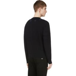

In [21]:
example = val_dataset[0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

In [22]:
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

long sleeve sweatshirt in navy. ribbed crewneck collar, sleeve cuffs and hem. metal plaque ' 17 ' at front. fleecy interior. tonal stitching.


# **Performance Analysis:**

In [23]:
from transformers import AutoModelForCausalLM, AutoProcessor
import torch
from PIL import Image
from datasets import load_dataset
import evaluate
from pycocoevalcap.cider.cider import Cider
# from pycocoevalcap.spice.spice import Spice

# Function to compute CIDEr
def compute_cider(predictions, references):
    scorer = Cider()
    score, _ = scorer.compute_score({i: [ref] for i, ref in enumerate(references)},
                                    {i: [pred] for i, pred in enumerate(predictions)})
    return score
# def compute_spice(predictions, references):
#     scorer = Spice()

#     gts = {i: [ref] for i, ref in enumerate(references)}
#     res = {i: [pred] for i, pred in enumerate(predictions)}

#     score, _ = scorer.compute_score(gts, res)
#     return score

# function to compute metrics
def evaluate_model(model, processor, dataset, device):
    model.eval()
    predictions = []
    references = []

    for example in val_dataset:
        image = example["image"]
        text = example["text"]

        inputs = processor(images=image, return_tensors="pt").to(device)
        pixel_values = inputs.pixel_values

        with torch.no_grad():
            generated_ids = model.generate(pixel_values=pixel_values, max_length=50)

        generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        predictions.append(generated_caption)
        references.append(text)

    # Load and compute BLEU and ROUGE metrics
    bleu_metric = evaluate.load("bleu")
    rouge_metric = evaluate.load("rouge")
    meteor_metric = evaluate.load("meteor")

    bleu_metric.add_batch(predictions=predictions, references=[[ref] for ref in references])
    rouge_metric.add_batch(predictions=predictions, references=references)
    meteor_metric.add_batch(predictions=predictions, references=references)

    bleu_result = bleu_metric.compute()
    rouge_result = rouge_metric.compute()
    cider_result = compute_cider(predictions, references)
    meteor_result = meteor_metric.compute()['meteor']
    # spice_result = compute_spice(predictions, references)

    # Create formatted result
    result = (
        f"BLEU:\n"
        f"  BLEU-1: {bleu_result['precisions'][0]:.4f}\n"
        f"  BLEU-2: {bleu_result['precisions'][1]:.4f}\n"
        f"  BLEU-3: {bleu_result['precisions'][2]:.4f}\n"
        f"  BLEU-4: {bleu_result['precisions'][3]:.4f}\n"
        f"  BLEU score: {bleu_result['bleu']:.4f}\n\n"
        f"ROUGE:\n"
        f"  ROUGE-1: {rouge_result['rouge1']:.4f}\n"
        f"  ROUGE-2: {rouge_result['rouge2']:.4f}\n"
        f"  ROUGE-L: {rouge_result['rougeL']:.4f}\n\n"
        f"METEOR: {meteor_result:.4f}\n"
        f"CIDEr: {cider_result:.4f}\n"
    )
    return result

In [ ]:
from transformers import AutoModelForCausalLM, AutoProcessor
import torch
model_path = 'last_model_caption_FG.pth'
premodel = AutoModelForCausalLM.from_pretrained("microsoft/git-base")
model = premodel

model.load_state_dict(torch.load(model_path))
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

In [ ]:
results = evaluate_model(model, processor, val_dataset, device)
print(results)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


BLEU:
  BLEU-1: 0.6241
  BLEU-2: 0.4346
  BLEU-3: 0.3005
  BLEU-4: 0.2222
  BLEU score: 0.3521

ROUGE:
  ROUGE-1: 0.7568
  ROUGE-2: 0.6708
  ROUGE-L: 0.7408

METEOR: 0.6928
CIDEr: 1.7542



In [33]:
# Evaluate metrics after fine-tuning
results = evaluate_model(model, processor, test_dataset, device)
print(results)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


BLEU:
  BLEU-1: 0.6107
  BLEU-2: 0.5377
  BLEU-3: 0.5301
  BLEU-4: 0.5282
  BLEU score: 0.5498

ROUGE:
  ROUGE-1: 0.6108
  ROUGE-2: 0.5397
  ROUGE-L: 0.5919

METEOR: 0.5825
CIDEr: 5.3178



In [ ]:
import random

random_indices = random.sample(range(len(test_dataset)), 5)
examples = [test_dataset[i] for i in random_indices]

for i, example in enumerate(examples):
    image = example["image"]
    actual_caption = example["text"]
    width, height = image.size

    display(image.resize((int(0.3 * width), int(0.3 * height))))

    inputs = processor(images=image, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values

    generated_ids = model.generate(pixel_values=pixel_values, max_length=128)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    print(f"Image {i + 1}:")
    print(f"  Actual Caption: {actual_caption}")
    print(f"  Generated Caption: {generated_caption}")
    print()
